<a href="https://colab.research.google.com/github/dhirajkrgupta/classical-models/blob/main/crossvalidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import make_scorer, accuracy_score,confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, roc_auc_score,roc_curve,auc
from sklearn.preprocessing import StandardScaler
import json
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# **Step 1: Data Preparation**

# **Step 3: Text Vectorization**


In [3]:
def create_text_features(texts, max_features=5000, ngram_range=(1, 2), vectorizer_type='tfidf'):
    """
    Create text features using different vectorization methods
    """
    # Clean and preprocess texts
    cleaned_texts = []
    for text in texts:
        if text and isinstance(text, str) and not pd.isna(text):
            cleaned_texts.append(str(text).strip())
        else:
            cleaned_texts.append("")

    # Choose vectorizer
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            strip_accents='ascii',
            min_df=2,
            max_df=0.95
        )
    elif vectorizer_type == 'count':
        vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            strip_accents='ascii',
            min_df=2,
            max_df=0.95
        )

    text_features = vectorizer.fit_transform(cleaned_texts)
    return text_features, vectorizer

# **Step 4: Model Training Pipeline**

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# compute matrix
def plotconfusino_matrix(conf_matrix):
    # define class labels
    classes = ["Human", "AI"]  # change to your own labels

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # tick marks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # put numbers in the cells
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(
                j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


In [5]:
class FlexibleAIHumanClassifier:
    """
    Flexible classifier that can use any sklearn classifier with cross-validation training
    """

    def __init__(self, classifier_name='logistic', max_features=3000, ngram_range=(1, 2),
                 vectorizer_type='tfidf', use_scaling=True, cv_folds=5):
        self.vectorizer = None
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.vectorizer_type = vectorizer_type
        self.classifier_name = classifier_name
        self.cv_folds = cv_folds
        self.cv_results = None

        # Initialize the classifier based on name
        self.model = self._get_classifier(classifier_name)

    def _get_classifier(self, classifier_name):
        """Get classifier by name with optimized parameters"""
        classifiers = {
            'logistic': LogisticRegression(random_state=42, max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'svm_linear': LinearSVC(C=1.0,max_iter=1000,tol=1e-3,dual=False,random_state=4),
            'naive_bayes_multinomial': MultinomialNB(),
            'knn': KNeighborsClassifier(n_neighbors=5),
            'decision_tree': DecisionTreeClassifier(random_state=42),
            'extra_trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'lda': LinearDiscriminantAnalysis(),
            'xgboost': XGBClassifier(random_state=42, n_jobs=-1),
            'mlp': MLPClassifier(random_state=42)
        }

        if classifier_name not in classifiers:
            raise ValueError(f"Classifier '{classifier_name}' not supported. Available: {list(classifiers.keys())}")

        return classifiers[classifier_name]

    def prepare_features(self, texts, fit_transform=True):
        """Prepare combined features (linguistic + text)"""
        if fit_transform:
          text_features, self.vectorizer = create_text_features(
              texts, self.max_features, self.ngram_range, self.vectorizer_type
          )
        else:
            # use the already-fitted vectorizer to just transform new texts
            cleaned_texts = [
                str(t).strip() if t and isinstance(t, str) and not pd.isna(t) else ""
                for t in texts
            ]
            text_features = self.vectorizer.transform(cleaned_texts)
        # Convert sparse to dense if the classifier requires it
        if isinstance(self.model, (GaussianNB, LinearDiscriminantAnalysis)):
            text_features = text_features.toarray()

        return text_features

    def train(self, X, y):
      """Train the classifier with cross-validation and custom metrics"""
      skf = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)

      metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'mcc': [],
        'cohen_kappa': [],
        'auc': []
      }
      # Storage for ROC curves
      tprs = []
      aucs = []
      mean_fpr = np.linspace(0, 1, 100)
      # Storage for confusion matrices
      conf_matrices = []

      print("=" * 60)
      print("K-FOLD CROSS-VALIDATION RESULTS")
      print("=" * 60)
      for fold,(train_idx, val_idx) in enumerate(skf.split(X, y),1):
          X_train, X_val = X[train_idx], X[val_idx]
          y_train, y_val = y[train_idx], y[val_idx]

          # vetorized the text data
          X_train_features = self.prepare_features(X_train, fit_transform=True)
          X_val_features = self.prepare_features(X_val, fit_transform=False)

          # Train model on this fold
          self.model.fit(X_train_features, y_train)

          # Evaluate on validation fold
          y_pred = self.model.predict(X_val_features)

          # Check if classifier has predict_proba for AUC calculation
          if hasattr(self.model, 'predict_proba'):
              y_proba = self.model.predict_proba(X_val_features)[:, 1]
              roc_auc = roc_auc_score(y_val, y_proba)
              metrics['auc'].append(roc_auc)

              fpr, tpr, _ = roc_curve(y_val, y_proba)
              tprs.append(np.interp(mean_fpr, fpr, tpr))
              tprs[-1][0] = 0.0
              aucs.append(roc_auc)
          else:
              metrics['auc'].append(np.nan) # Append NaN if AUC is not calculated


          # Calculate metrics
          acc = accuracy_score(y_val, y_pred)
          prec = precision_score(y_val, y_pred, average='binary')
          rec = recall_score(y_val, y_pred, average='binary')
          f1 = f1_score(y_val, y_pred, average='binary')
          mcc = matthews_corrcoef(y_val, y_pred)
          kappa = cohen_kappa_score(y_val, y_pred)


          #  Store metrics
          metrics['accuracy'].append(acc)
          metrics['precision'].append(prec)
          metrics['recall'].append(rec)
          metrics['f1_score'].append(f1)
          metrics['mcc'].append(mcc)
          metrics['cohen_kappa'].append(kappa)


          conf_matrices.append(confusion_matrix(y_val, y_pred))

          print(f"\nFold {fold}:")
          print(f"  Accuracy:      {acc:.4f}")
          print(f"  Precision:     {prec:.4f}")
          print(f"  Recall:        {rec:.4f}")
          print(f"  F1-Score:      {f1:.4f}")
          print(f"  MCC:           {mcc:.4f}")
          print(f"  Cohen's Kappa: {kappa:.4f}")
          if hasattr(self.model, 'predict_proba'):
              print(f"  AUC-ROC:       {roc_auc:.4f}")
          else:
              print("  AUC-ROC:       N/A (Classifier does not support predict_proba)")


      # Aggregate across folds
      print("\n" + "=" * 60)
      print("OVERALL RESULTS (Mean ± Std)")
      print("=" * 60)

      for metric_name, values in metrics.items():
          mean_val = np.nanmean(values) # Use nanmean to handle NaN values
          std_val = np.nanstd(values) # Use nanstd to handle NaN values
          if metric_name == 'auc' and np.isnan(mean_val):
              print(f"{metric_name.replace('_', ' ').title():15s}: N/A (Classifier does not support predict_proba)")
          else:
              print(f"{metric_name.replace('_', ' ').title():15s}: {mean_val:.4f} ± {std_val:.4f}")


      # Average confusion matrix
      avg_conf_matrix = np.mean(conf_matrices, axis=0).astype(int)

      # Plot mean ROC curve only if AUC was calculated
      if any(~np.isnan(metrics['auc'])):
          mean_tpr = np.mean(tprs, axis=0)
          mean_tpr[-1] = 1.0
          mean_auc = auc(mean_fpr, mean_tpr)
          std_auc = np.std(aucs)

          plt.plot(mean_fpr, mean_tpr, color='blue', lw=2,
                  label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')

          # Plot standard deviation
          std_tpr = np.std(tprs, axis=0)
          tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
          tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
          plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey',
                          alpha=0.2, label='± 1 std. dev.')
          # Plot diagonal line
          plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')

          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('False Positive Rate', fontsize=12)
          plt.ylabel('True Positive Rate', fontsize=12)
          plt.title('ROC Curves - K-Fold Cross-Validation', fontsize=14, fontweight='bold')
          plt.legend(loc="lower right", fontsize=10)
          plt.grid(alpha=0.3)
          plt.tight_layout()
          plt.show()
      else:
          print("\nROC curve not plotted: Classifier does not support probability predictions.")


      # Plot confusion matrix heatmap
      plotconfusino_matrix(avg_conf_matrix)

      print("\n" + "=" * 60)
      print("Visualization complete!")
      print("=" * 60)

def predict(self, X_test):
        """Predict labels for test data"""
        X_test_features = self.prepare_features(X_test, fit_transform=False)
        return self.model.predict(X_test_features)

# **Step 6: Usage Example**

In [7]:
import sys
import csv

def train_single_classifier(classifier_name='random_forest',cv_folds=5):
    """
    Train a single classifier
    """
    # Increase the field size limit for CSV reader
    csv.field_size_limit(sys.maxsize)

    # Load data
    train_df = pd.read_csv("/content/subtaskA.csv", engine='python')

    # Drop rows with missing labels
    train_df.dropna(subset=['label'], inplace=True)

    # Reset index after dropping rows
    train_df.reset_index(drop=True, inplace=True)

    # Split data
    X = train_df['text']
    y = train_df['label']

    # Train classifier
    classifier = FlexibleAIHumanClassifier(classifier_name=classifier_name,cv_folds=cv_folds)
    classifier.train(X, y)

    return classifier

**Logistic Regression**

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.8693
  Precision:     0.8820
  Recall:        0.9290
  F1-Score:      0.9049
  MCC:           0.6991
  Cohen's Kappa: 0.6967
  AUC-ROC:       0.9359

Fold 2:
  Accuracy:      0.8662
  Precision:     0.8787
  Recall:        0.9281
  F1-Score:      0.9027
  MCC:           0.6916
  Cohen's Kappa: 0.6889
  AUC-ROC:       0.9329

Fold 3:
  Accuracy:      0.8706
  Precision:     0.8830
  Recall:        0.9297
  F1-Score:      0.9058
  MCC:           0.7022
  Cohen's Kappa: 0.6998
  AUC-ROC:       0.9373

Fold 4:
  Accuracy:      0.8682
  Precision:     0.8808
  Recall:        0.9286
  F1-Score:      0.9041
  MCC:           0.6964
  Cohen's Kappa: 0.6939
  AUC-ROC:       0.9343

Fold 5:
  Accuracy:      0.8661
  Precision:     0.8807
  Recall:        0.9252
  F1-Score:      0.9024
  MCC:           0.6918
  Cohen's Kappa: 0.6897
  AUC-ROC:       0.9333

OVERALL RESULTS (Mean ± Std)
Accuracy       : 0.8681 ± 0.0018
Precision      : 0.8

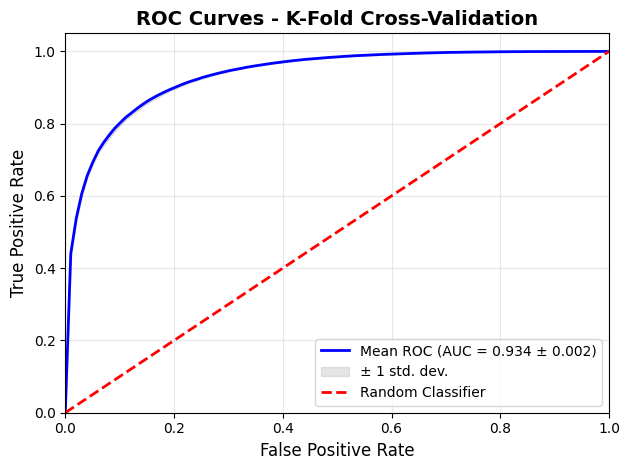

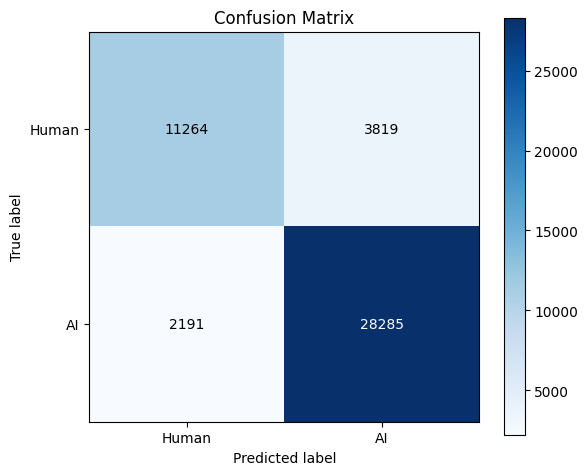


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='logistic',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.8704
  Precision:     0.8826
  Recall:        0.9299
  F1-Score:      0.9056
  MCC:           0.7016
  Cohen's Kappa: 0.6991
  AUC-ROC:       0.9354

Fold 2:
  Accuracy:      0.8682
  Precision:     0.8815
  Recall:        0.9277
  F1-Score:      0.9040
  MCC:           0.6966
  Cohen's Kappa: 0.6943
  AUC-ROC:       0.9371

Fold 3:
  Accuracy:      0.8661
  Precision:     0.8802
  Recall:        0.9259
  F1-Score:      0.9025
  MCC:           0.6918
  Cohen's Kappa: 0.6895
  AUC-ROC:       0.9344

Fold 4:
  Accuracy:      0.8685
  Precision:     0.8819
  Recall:        0.9277
  F1-Score:      0.9042
  MCC:           0.6974
  Cohen's Kappa: 0.6951
  AUC-ROC:       0.9350

Fold 5:
  Accuracy:      0.8723
  Precision:     0.8857
  Recall:        0.9290
  F1-Score:      0.9069
  MCC:           0.7065
  Cohen's Kappa: 0.7044
  AUC-ROC:       0.9371

Fold 6:
  Accuracy:      0.8683
  Precision:     0.8812
  Recall:        0.9281
  

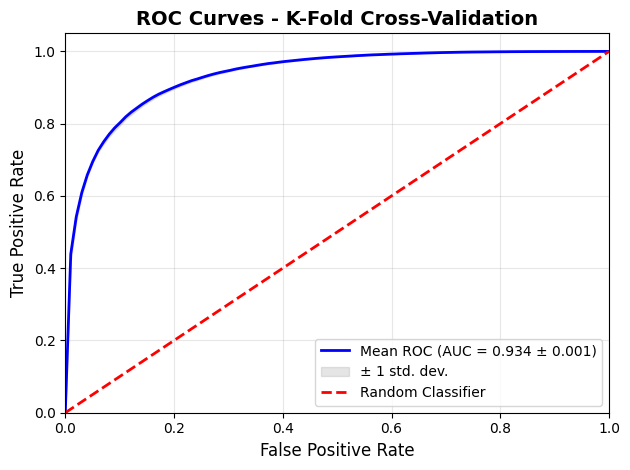

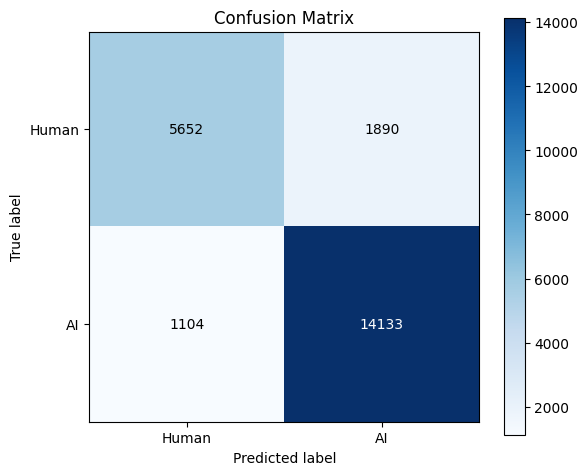


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='logistic',cv_folds=10)

**MLP**

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.9516
  Precision:     0.9507
  Recall:        0.9785
  F1-Score:      0.9644
  MCC:           0.8900
  Cohen's Kappa: 0.8891
  AUC-ROC:       0.9869

Fold 2:
  Accuracy:      0.9507
  Precision:     0.9542
  Recall:        0.9731
  F1-Score:      0.9635
  MCC:           0.8880
  Cohen's Kappa: 0.8876
  AUC-ROC:       0.9854

Fold 3:
  Accuracy:      0.9493
  Precision:     0.9489
  Recall:        0.9767
  F1-Score:      0.9626
  MCC:           0.8846
  Cohen's Kappa: 0.8837
  AUC-ROC:       0.9860

Fold 4:
  Accuracy:      0.9478
  Precision:     0.9468
  Recall:        0.9768
  F1-Score:      0.9616
  MCC:           0.8812
  Cohen's Kappa: 0.8801
  AUC-ROC:       0.9865

Fold 5:
  Accuracy:      0.9495
  Precision:     0.9528
  Recall:        0.9726
  F1-Score:      0.9626
  MCC:           0.8852
  Cohen's Kappa: 0.8847
  AUC-ROC:       0.9860

OVERALL RESULTS (Mean ± Std)
Accuracy       : 0.9498 ± 0.0013
Precision      : 0.9

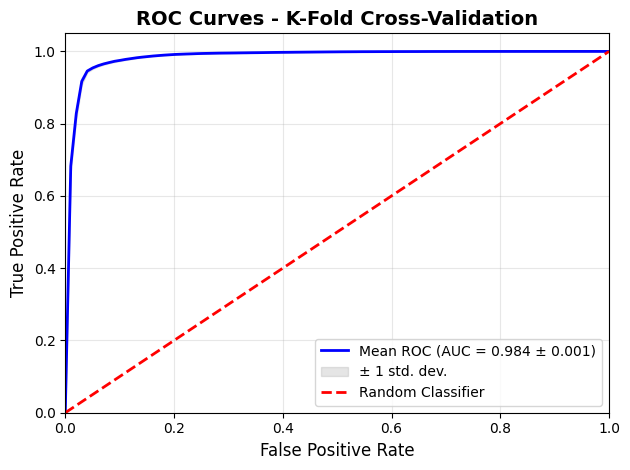

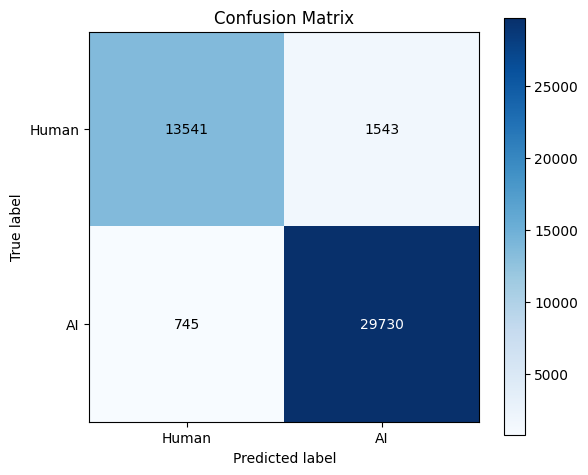


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='mlp',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.9601
  Precision:     0.9554
  Recall:        0.9864
  F1-Score:      0.9706
  MCC:           0.9095
  Cohen's Kappa: 0.9084
  AUC-ROC:       0.9891

Fold 2:
  Accuracy:      0.9608
  Precision:     0.9565
  Recall:        0.9862
  F1-Score:      0.9711
  MCC:           0.9111
  Cohen's Kappa: 0.9101
  AUC-ROC:       0.9900

Fold 3:
  Accuracy:      0.9522
  Precision:     0.9479
  Recall:        0.9824
  F1-Score:      0.9649
  MCC:           0.8913
  Cohen's Kappa: 0.8899
  AUC-ROC:       0.9859

Fold 4:
  Accuracy:      0.9595
  Precision:     0.9566
  Recall:        0.9841
  F1-Score:      0.9701
  MCC:           0.9080
  Cohen's Kappa: 0.9072
  AUC-ROC:       0.9898

Fold 5:
  Accuracy:      0.9568
  Precision:     0.9526
  Recall:        0.9844
  F1-Score:      0.9682
  MCC:           0.9020
  Cohen's Kappa: 0.9008
  AUC-ROC:       0.9889

Fold 6:
  Accuracy:      0.9494
  Precision:     0.9438
  Recall:        0.9829
  

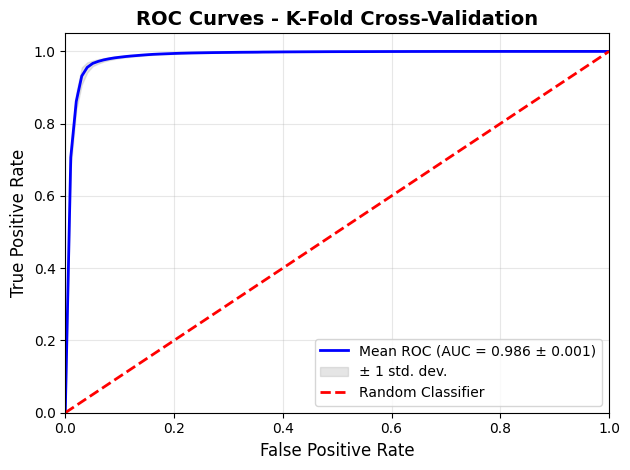

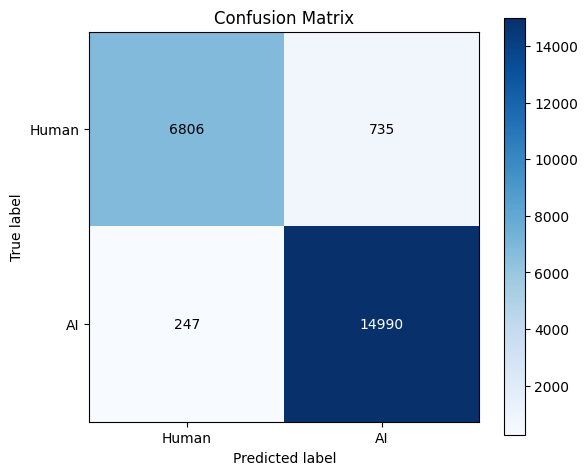


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='mlp',cv_folds=10)

**Random forest**

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.9198
  Precision:     0.9020
  Recall:        0.9874
  F1-Score:      0.9427
  MCC:           0.8190
  Cohen's Kappa: 0.8097
  AUC-ROC:       0.9873

Fold 2:
  Accuracy:      0.9182
  Precision:     0.9005
  Recall:        0.9868
  F1-Score:      0.9417
  MCC:           0.8154
  Cohen's Kappa: 0.8059
  AUC-ROC:       0.9867

Fold 3:
  Accuracy:      0.9200
  Precision:     0.9034
  Recall:        0.9858
  F1-Score:      0.9428
  MCC:           0.8193
  Cohen's Kappa: 0.8107
  AUC-ROC:       0.9863

Fold 4:
  Accuracy:      0.9189
  Precision:     0.9023
  Recall:        0.9854
  F1-Score:      0.9420
  MCC:           0.8166
  Cohen's Kappa: 0.8078
  AUC-ROC:       0.9865

Fold 5:
  Accuracy:      0.9179
  Precision:     0.9003
  Recall:        0.9865
  F1-Score:      0.9414
  MCC:           0.8146
  Cohen's Kappa: 0.8052
  AUC-ROC:       0.9863

OVERALL RESULTS (Mean ± Std)
Accuracy       : 0.9190 ± 0.0008
Precision      : 0.9

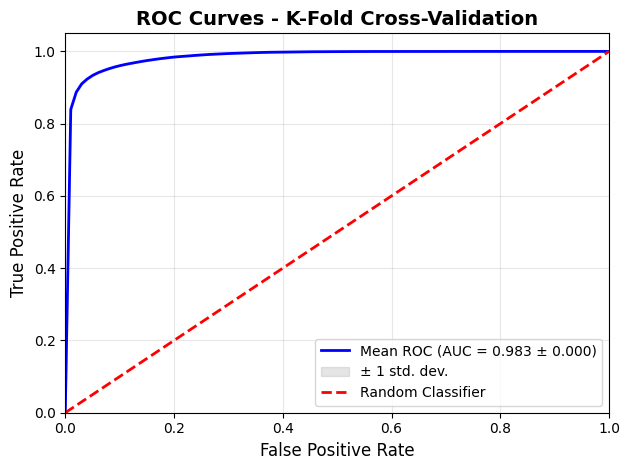

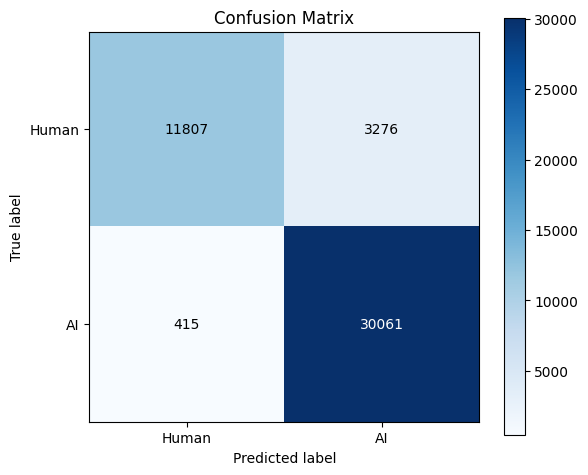


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='random_forest',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.9286
  Precision:     0.9093
  Recall:        0.9923
  F1-Score:      0.9489
  MCC:           0.8397
  Cohen's Kappa: 0.8309
  AUC-ROC:       0.9922

Fold 2:
  Accuracy:      0.9284
  Precision:     0.9104
  Recall:        0.9905
  F1-Score:      0.9487
  MCC:           0.8389
  Cohen's Kappa: 0.8308
  AUC-ROC:       0.9917

Fold 3:
  Accuracy:      0.9248
  Precision:     0.9052
  Recall:        0.9914
  F1-Score:      0.9463
  MCC:           0.8311
  Cohen's Kappa: 0.8216
  AUC-ROC:       0.9914

Fold 4:
  Accuracy:      0.9291
  Precision:     0.9114
  Recall:        0.9902
  F1-Score:      0.9492
  MCC:           0.8404
  Cohen's Kappa: 0.8326
  AUC-ROC:       0.9916

Fold 5:
  Accuracy:      0.9286
  Precision:     0.9108
  Recall:        0.9902
  F1-Score:      0.9489
  MCC:           0.8394
  Cohen's Kappa: 0.8314
  AUC-ROC:       0.9905

Fold 6:
  Accuracy:      0.9306
  Precision:     0.9123
  Recall:        0.9915
  

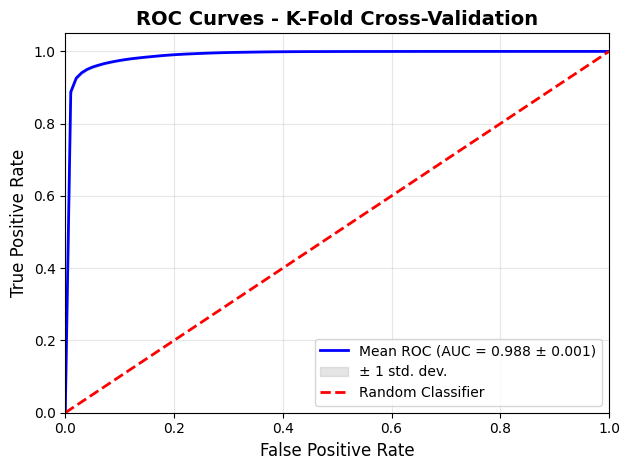

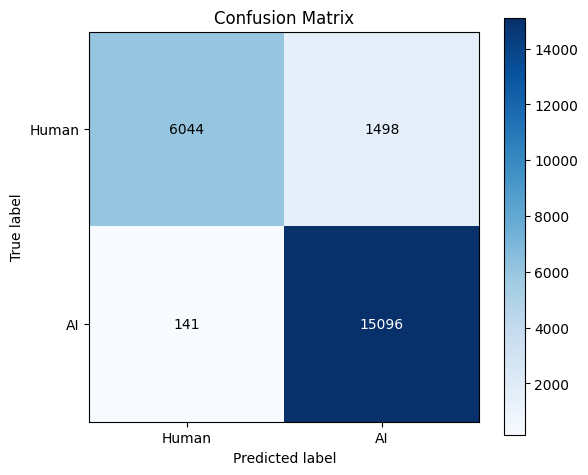


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='random_forest',cv_folds=10)

**Naive Bayes**

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.7685
  Precision:     0.8073
  Recall:        0.8588
  F1-Score:      0.8323
  MCC:           0.4620
  Cohen's Kappa: 0.4597
  AUC-ROC:       0.7818

Fold 2:
  Accuracy:      0.7635
  Precision:     0.8047
  Recall:        0.8536
  F1-Score:      0.8284
  MCC:           0.4510
  Cohen's Kappa: 0.4490
  AUC-ROC:       0.7749

Fold 3:
  Accuracy:      0.7673
  Precision:     0.8068
  Recall:        0.8574
  F1-Score:      0.8313
  MCC:           0.4594
  Cohen's Kappa: 0.4572
  AUC-ROC:       0.7815

Fold 4:
  Accuracy:      0.7621
  Precision:     0.8049
  Recall:        0.8505
  F1-Score:      0.8271
  MCC:           0.4486
  Cohen's Kappa: 0.4468
  AUC-ROC:       0.7734

Fold 5:
  Accuracy:      0.7688
  Precision:     0.8071
  Recall:        0.8598
  F1-Score:      0.8326
  MCC:           0.4624
  Cohen's Kappa: 0.4600
  AUC-ROC:       0.7804

OVERALL RESULTS (Mean ± Std)
Accuracy       : 0.7660 ± 0.0027
Precision      : 0.8

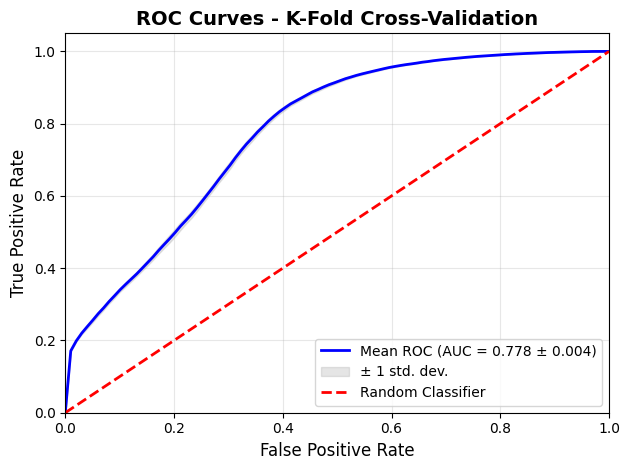

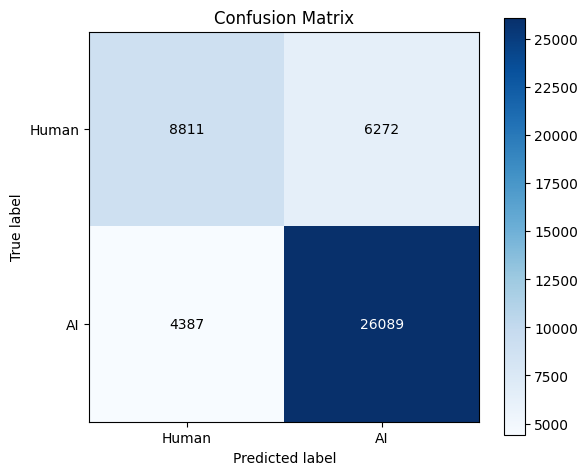


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='naive_bayes_multinomial',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.7696
  Precision:     0.8084
  Recall:        0.8592
  F1-Score:      0.8330
  MCC:           0.4648
  Cohen's Kappa: 0.4626
  AUC-ROC:       0.7818

Fold 2:
  Accuracy:      0.7667
  Precision:     0.8064
  Recall:        0.8570
  F1-Score:      0.8309
  MCC:           0.4581
  Cohen's Kappa: 0.4559
  AUC-ROC:       0.7807

Fold 3:
  Accuracy:      0.7635
  Precision:     0.8054
  Recall:        0.8525
  F1-Score:      0.8283
  MCC:           0.4516
  Cohen's Kappa: 0.4497
  AUC-ROC:       0.7744

Fold 4:
  Accuracy:      0.7652
  Precision:     0.8052
  Recall:        0.8561
  F1-Score:      0.8299
  MCC:           0.4545
  Cohen's Kappa: 0.4523
  AUC-ROC:       0.7767

Fold 5:
  Accuracy:      0.7669
  Precision:     0.8070
  Recall:        0.8563
  F1-Score:      0.8309
  MCC:           0.4588
  Cohen's Kappa: 0.4567
  AUC-ROC:       0.7823

Fold 6:
  Accuracy:      0.7674
  Precision:     0.8062
  Recall:        0.8587
  

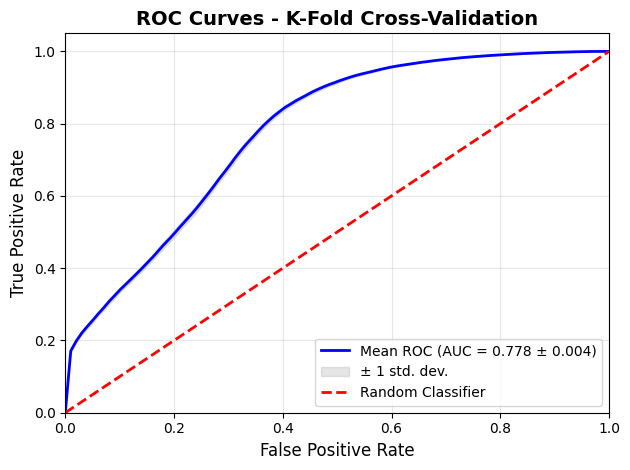

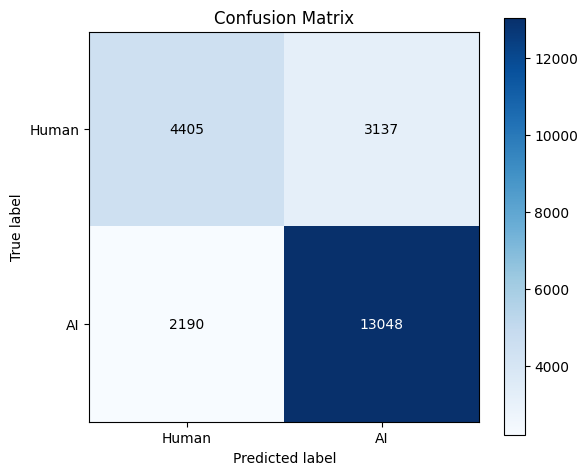


Visualization complete!


In [8]:
train_single_classifier(classifier_name='naive_bayes_multinomial',cv_folds=10)

KNN

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.7269
  Precision:     0.7201
  Recall:        0.9681
  F1-Score:      0.8259
  MCC:           0.3248
  Cohen's Kappa: 0.2519
  AUC-ROC:       0.7287

Fold 2:
  Accuracy:      0.7252
  Precision:     0.7177
  Recall:        0.9710
  F1-Score:      0.8254
  MCC:           0.3201
  Cohen's Kappa: 0.2433
  AUC-ROC:       0.7208

Fold 3:
  Accuracy:      0.7259
  Precision:     0.7184
  Recall:        0.9708
  F1-Score:      0.8257
  MCC:           0.3224
  Cohen's Kappa: 0.2460
  AUC-ROC:       0.7256

Fold 4:
  Accuracy:      0.7266
  Precision:     0.7191
  Recall:        0.9704
  F1-Score:      0.8260
  MCC:           0.3246
  Cohen's Kappa: 0.2488
  AUC-ROC:       0.7252

Fold 5:
  Accuracy:      0.7279
  Precision:     0.7209
  Recall:        0.9679
  F1-Score:      0.8264
  MCC:           0.3280
  Cohen's Kappa: 0.2556
  AUC-ROC:       0.7328

OVERALL RESULTS (Mean ± Std)
Accuracy       : 0.7265 ± 0.0009
Precision      : 0.7

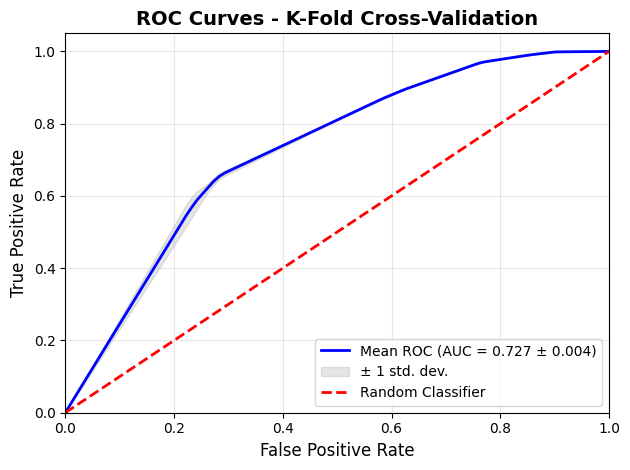

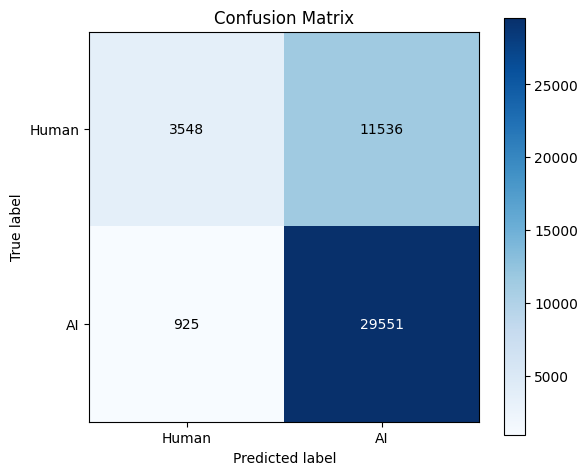


Visualization complete!


In [ ]:

train_single_classifier(classifier_name='knn',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.7304
  Precision:     0.7222
  Recall:        0.9703
  F1-Score:      0.8280
  MCC:           0.3371
  Cohen's Kappa: 0.2620
  AUC-ROC:       0.7401

Fold 2:
  Accuracy:      0.7296
  Precision:     0.7223
  Recall:        0.9678
  F1-Score:      0.8272
  MCC:           0.3336
  Cohen's Kappa: 0.2616
  AUC-ROC:       0.7429

Fold 3:
  Accuracy:      0.7305
  Precision:     0.7222
  Recall:        0.9703
  F1-Score:      0.8281
  MCC:           0.3375
  Cohen's Kappa: 0.2624
  AUC-ROC:       0.7376

Fold 4:
  Accuracy:      0.7308
  Precision:     0.7211
  Recall:        0.9745
  F1-Score:      0.8289
  MCC:           0.3402
  Cohen's Kappa: 0.2595
  AUC-ROC:       0.7302

Fold 5:
  Accuracy:      0.7318
  Precision:     0.7226
  Recall:        0.9724
  F1-Score:      0.8291
  MCC:           0.3423
  Cohen's Kappa: 0.2648
  AUC-ROC:       0.7352

Fold 6:
  Accuracy:      0.7336
  Precision:     0.7246
  Recall:        0.9706
  

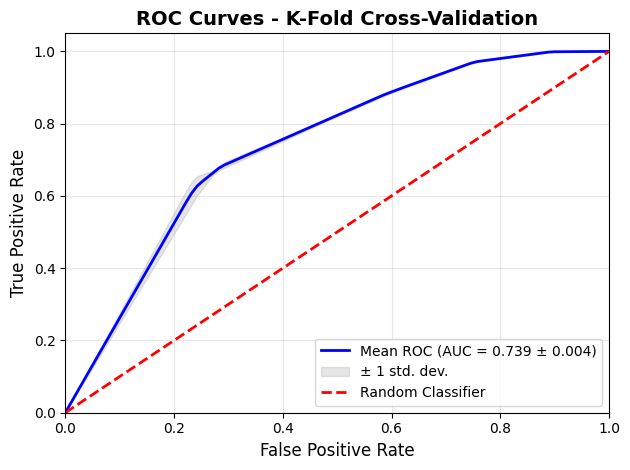

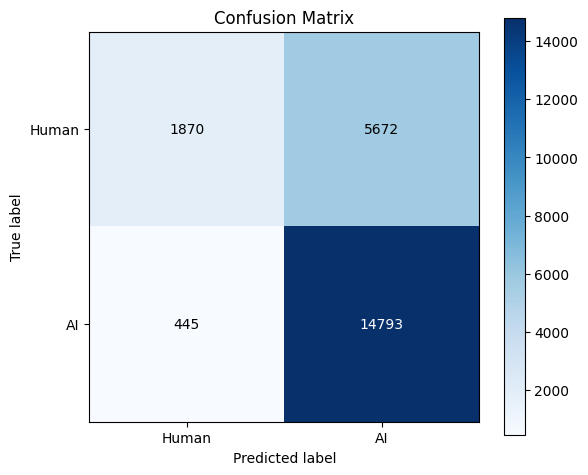


Visualization complete!


In [8]:
train_single_classifier(classifier_name='knn',cv_folds=10)

**Decision Tree**

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.8881
  Precision:     0.8940
  Recall:        0.9449
  F1-Score:      0.9187
  MCC:           0.7428
  Cohen's Kappa: 0.7399
  AUC-ROC:       0.8592

Fold 2:
  Accuracy:      0.8865
  Precision:     0.8927
  Recall:        0.9438
  F1-Score:      0.9175
  MCC:           0.7390
  Cohen's Kappa: 0.7361
  AUC-ROC:       0.8574

Fold 3:
  Accuracy:      0.8849
  Precision:     0.8919
  Recall:        0.9422
  F1-Score:      0.9163
  MCC:           0.7353
  Cohen's Kappa: 0.7325
  AUC-ROC:       0.8559

Fold 4:
  Accuracy:      0.8839
  Precision:     0.8909
  Recall:        0.9417
  F1-Score:      0.9156
  MCC:           0.7329
  Cohen's Kappa: 0.7300
  AUC-ROC:       0.8544

Fold 5:
  Accuracy:      0.8865
  Precision:     0.8914
  Recall:        0.9456
  F1-Score:      0.9177
  MCC:           0.7390
  Cohen's Kappa: 0.7357
  AUC-ROC:       0.8566

OVERALL RESULTS (Mean ± Std)
Accuracy       : 0.8860 ± 0.0015
Precision      : 0.8

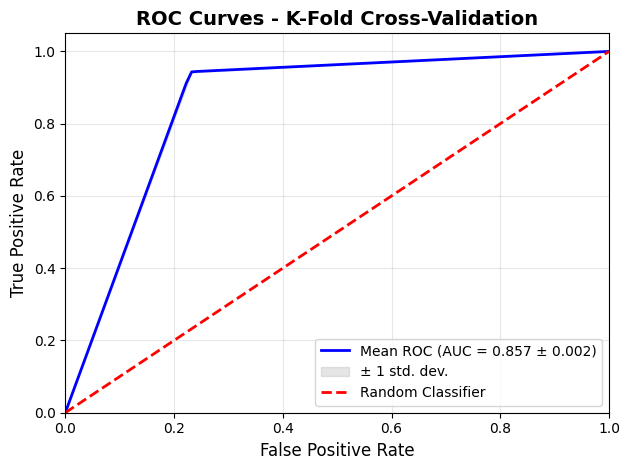

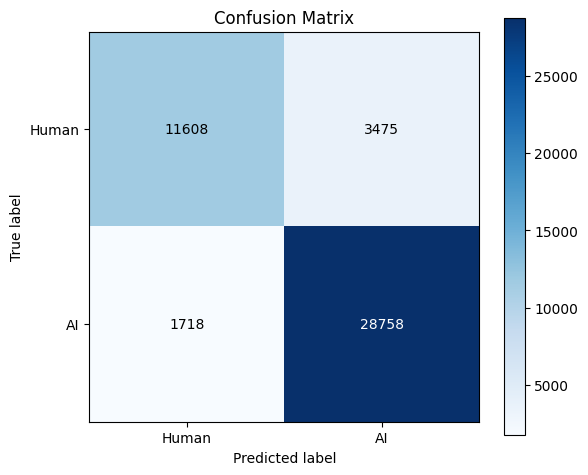


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='decision_tree',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.9047
  Precision:     0.9020
  Recall:        0.9621
  F1-Score:      0.9311
  MCC:           0.7816
  Cohen's Kappa: 0.7774
  AUC-ROC:       0.8754

Fold 2:
  Accuracy:      0.9009
  Precision:     0.8972
  Recall:        0.9620
  F1-Score:      0.9285
  MCC:           0.7726
  Cohen's Kappa: 0.7677
  AUC-ROC:       0.8696

Fold 3:
  Accuracy:      0.8995
  Precision:     0.8996
  Recall:        0.9565
  F1-Score:      0.9272
  MCC:           0.7694
  Cohen's Kappa: 0.7656
  AUC-ROC:       0.8705

Fold 4:
  Accuracy:      0.9019
  Precision:     0.8997
  Recall:        0.9605
  F1-Score:      0.9291
  MCC:           0.7750
  Cohen's Kappa: 0.7707
  AUC-ROC:       0.8721

Fold 5:
  Accuracy:      0.8983
  Precision:     0.8986
  Recall:        0.9559
  F1-Score:      0.9264
  MCC:           0.7666
  Cohen's Kappa: 0.7627
  AUC-ROC:       0.8691

Fold 6:
  Accuracy:      0.8987
  Precision:     0.8992
  Recall:        0.9557
  

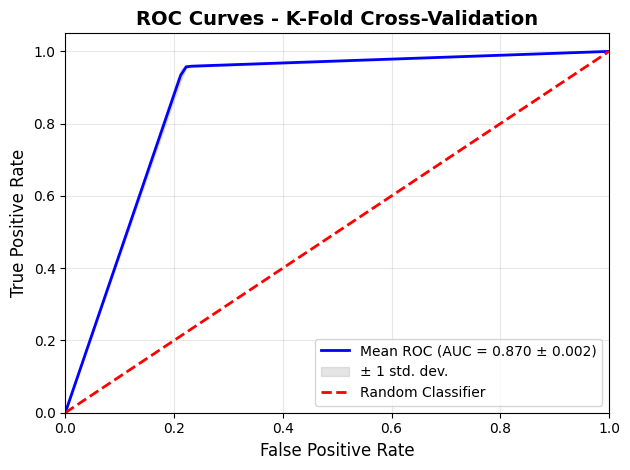

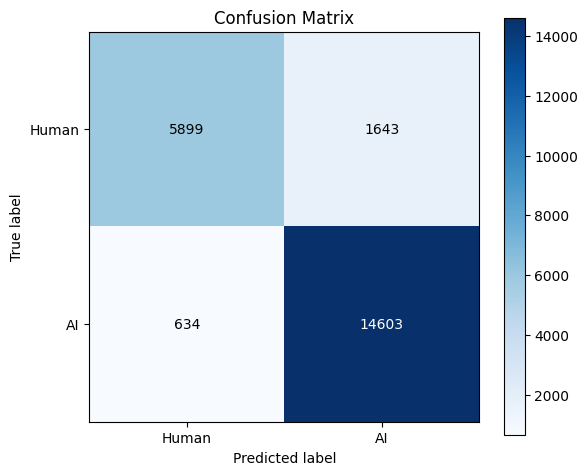


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='decision_tree',cv_folds=10)

**Extra Trees**

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.9283
  Precision:     0.9145
  Recall:        0.9849
  F1-Score:      0.9484
  MCC:           0.8377
  Cohen's Kappa: 0.8315
  AUC-ROC:       0.9898

Fold 2:
  Accuracy:      0.9264
  Precision:     0.9114
  Recall:        0.9858
  F1-Score:      0.9471
  MCC:           0.8336
  Cohen's Kappa: 0.8266
  AUC-ROC:       0.9893

Fold 3:
  Accuracy:      0.9281
  Precision:     0.9152
  Recall:        0.9836
  F1-Score:      0.9482
  MCC:           0.8371
  Cohen's Kappa: 0.8313
  AUC-ROC:       0.9891

Fold 4:
  Accuracy:      0.9287
  Precision:     0.9166
  Recall:        0.9829
  F1-Score:      0.9486
  MCC:           0.8383
  Cohen's Kappa: 0.8329
  AUC-ROC:       0.9891

Fold 5:
  Accuracy:      0.9266
  Precision:     0.9132
  Recall:        0.9838
  F1-Score:      0.9471
  MCC:           0.8336
  Cohen's Kappa: 0.8274
  AUC-ROC:       0.9887

OVERALL RESULTS (Mean ± Std)
Accuracy       : 0.9276 ± 0.0010
Precision      : 0.9

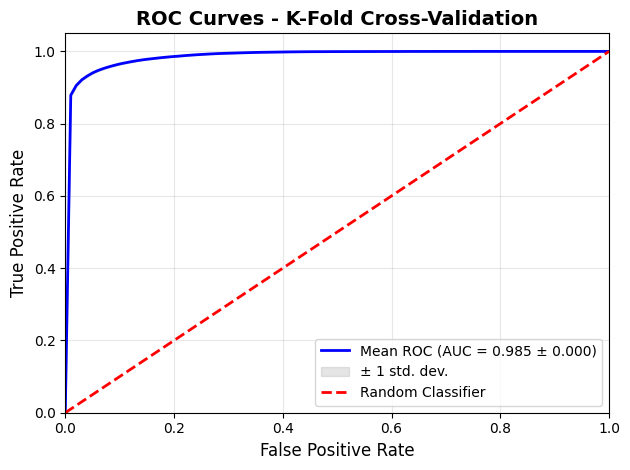

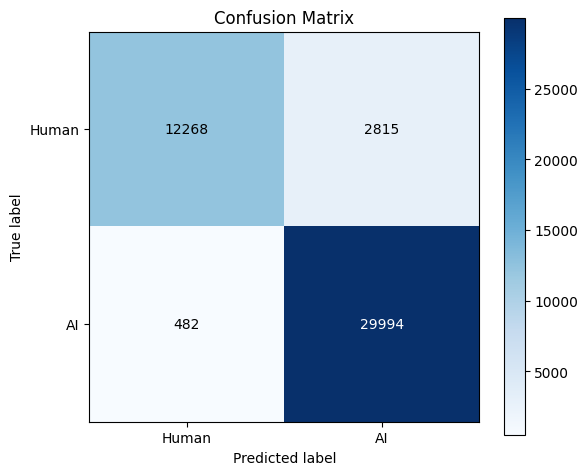


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='extra_trees',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.9389
  Precision:     0.9244
  Recall:        0.9896
  F1-Score:      0.9559
  MCC:           0.8622
  Cohen's Kappa: 0.8569
  AUC-ROC:       0.9940

Fold 2:
  Accuracy:      0.9386
  Precision:     0.9238
  Recall:        0.9899
  F1-Score:      0.9557
  MCC:           0.8616
  Cohen's Kappa: 0.8562
  AUC-ROC:       0.9935

Fold 3:
  Accuracy:      0.9349
  Precision:     0.9203
  Recall:        0.9883
  F1-Score:      0.9531
  MCC:           0.8530
  Cohen's Kappa: 0.8473
  AUC-ROC:       0.9934

Fold 4:
  Accuracy:      0.9372
  Precision:     0.9227
  Recall:        0.9889
  F1-Score:      0.9547
  MCC:           0.8582
  Cohen's Kappa: 0.8528
  AUC-ROC:       0.9936

Fold 5:
  Accuracy:      0.9407
  Precision:     0.9272
  Recall:        0.9890
  F1-Score:      0.9571
  MCC:           0.8661
  Cohen's Kappa: 0.8614
  AUC-ROC:       0.9932

Fold 6:
  Accuracy:      0.9386
  Precision:     0.9246
  Recall:        0.9888
  

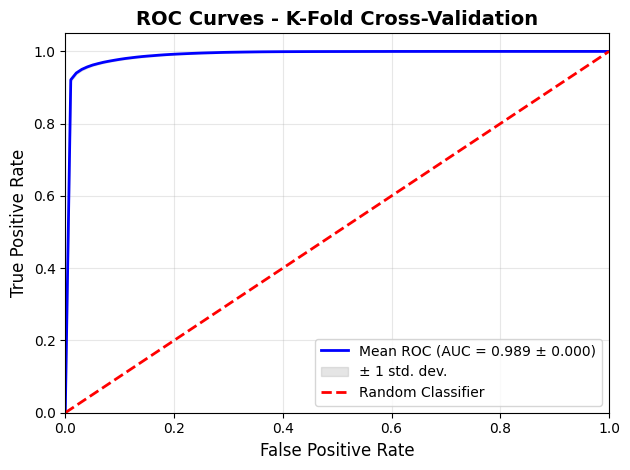

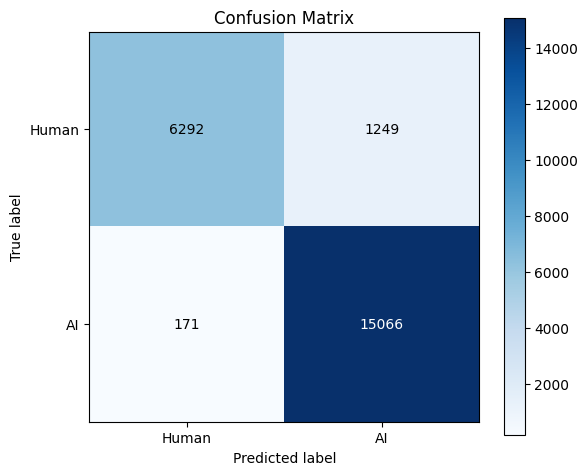


Visualization complete!


In [9]:
train_single_classifier(classifier_name='extra_trees',cv_folds=10)

**LDA**

In [ ]:
train_single_classifier(classifier_name='lda',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS


In [ ]:
train_single_classifier(classifier_name='lda',cv_folds=10)

test_accuracy: 0.9587 +/- 0.0201
test_precision: 0.9432 +/- 0.0219
test_recall: 0.9774 +/- 0.0392
test_f1: 0.9594 +/- 0.0207


**xgboost**

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.8819
  Precision:     0.8765
  Recall:        0.9585
  F1-Score:      0.9157
  MCC:           0.7280
  Cohen's Kappa: 0.7199
  AUC-ROC:       0.9515

Fold 2:
  Accuracy:      0.8801
  Precision:     0.8734
  Recall:        0.9600
  F1-Score:      0.9146
  MCC:           0.7240
  Cohen's Kappa: 0.7150
  AUC-ROC:       0.9505

Fold 3:
  Accuracy:      0.8825
  Precision:     0.8776
  Recall:        0.9580
  F1-Score:      0.9160
  MCC:           0.7295
  Cohen's Kappa: 0.7217
  AUC-ROC:       0.9525

Fold 4:
  Accuracy:      0.8853
  Precision:     0.8788
  Recall:        0.9610
  F1-Score:      0.9181
  MCC:           0.7361
  Cohen's Kappa: 0.7280
  AUC-ROC:       0.9531

Fold 5:
  Accuracy:      0.8782
  Precision:     0.8728
  Recall:        0.9575
  F1-Score:      0.9132
  MCC:           0.7193
  Cohen's Kappa: 0.7107
  AUC-ROC:       0.9514

OVERALL RESULTS (Mean ± Std)
Accuracy       : 0.8816 ± 0.0024
Precision      : 0.8

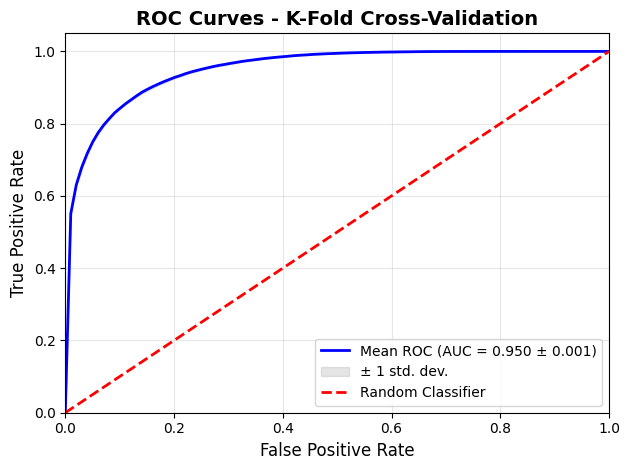

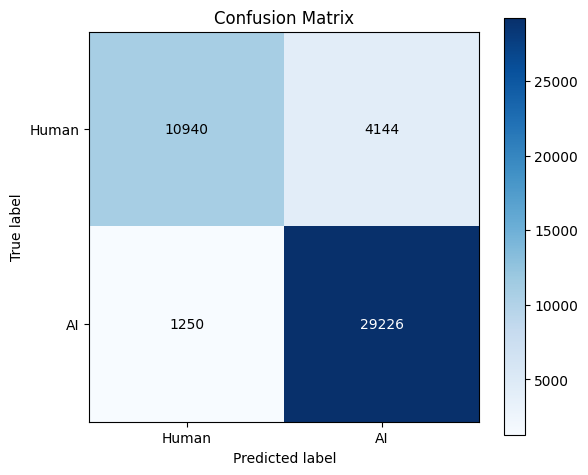


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='xgboost',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.8795
  Precision:     0.8749
  Recall:        0.9566
  F1-Score:      0.9139
  MCC:           0.7222
  Cohen's Kappa: 0.7142
  AUC-ROC:       0.9519

Fold 2:
  Accuracy:      0.8837
  Precision:     0.8766
  Recall:        0.9614
  F1-Score:      0.9171
  MCC:           0.7325
  Cohen's Kappa: 0.7238
  AUC-ROC:       0.9528

Fold 3:
  Accuracy:      0.8806
  Precision:     0.8737
  Recall:        0.9604
  F1-Score:      0.9150
  MCC:           0.7252
  Cohen's Kappa: 0.7161
  AUC-ROC:       0.9517

Fold 4:
  Accuracy:      0.8824
  Precision:     0.8779
  Recall:        0.9574
  F1-Score:      0.9159
  MCC:           0.7292
  Cohen's Kappa: 0.7216
  AUC-ROC:       0.9536

Fold 5:
  Accuracy:      0.8836
  Precision:     0.8780
  Recall:        0.9593
  F1-Score:      0.9168
  MCC:           0.7321
  Cohen's Kappa: 0.7241
  AUC-ROC:       0.9528

Fold 6:
  Accuracy:      0.8835
  Precision:     0.8796
  Recall:        0.9569
  

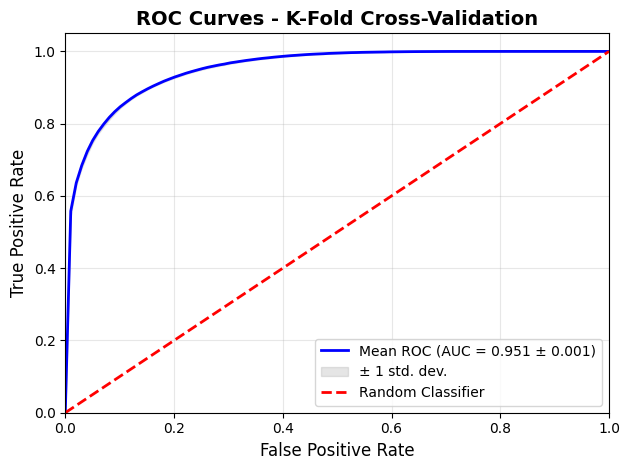

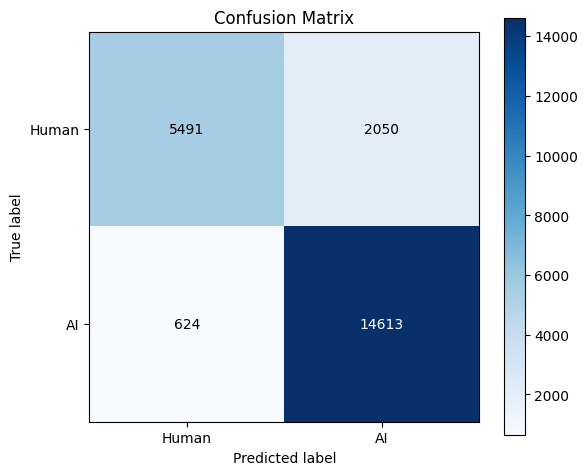


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='xgboost',cv_folds=10)

***SVM***

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.8719
  Precision:     0.8868
  Recall:        0.9269
  F1-Score:      0.9064
  MCC:           0.7058
  Cohen's Kappa: 0.7040
  AUC-ROC:       N/A (Classifier does not support predict_proba)

Fold 2:
  Accuracy:      0.8703
  Precision:     0.8863
  Recall:        0.9248
  F1-Score:      0.9051
  MCC:           0.7021
  Cohen's Kappa: 0.7006
  AUC-ROC:       N/A (Classifier does not support predict_proba)

Fold 3:
  Accuracy:      0.8733
  Precision:     0.8882
  Recall:        0.9273
  F1-Score:      0.9073
  MCC:           0.7091
  Cohen's Kappa: 0.7074
  AUC-ROC:       N/A (Classifier does not support predict_proba)

Fold 4:
  Accuracy:      0.8720
  Precision:     0.8872
  Recall:        0.9263
  F1-Score:      0.9064
  MCC:           0.7059
  Cohen's Kappa: 0.7043
  AUC-ROC:       N/A (Classifier does not support predict_proba)

Fold 5:
  Accuracy:      0.8710
  Precision:     0.8882
  Recall:        0.9235
  F1-Score:    

/tmp/ipython-input-1240582411.py:148: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(values) # Use nanmean to handle NaN values
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


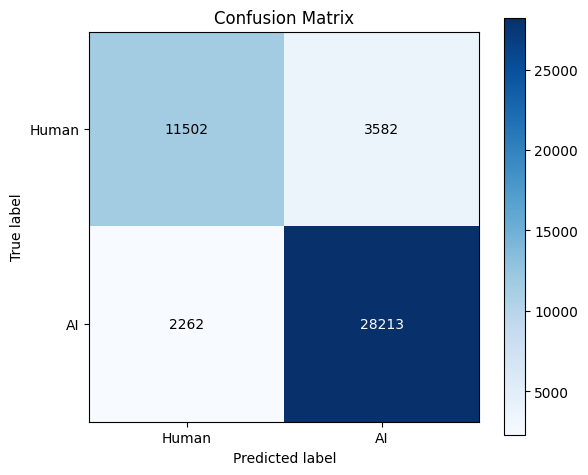


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='svm_linear',cv_folds=5)

K-FOLD CROSS-VALIDATION RESULTS

Fold 1:
  Accuracy:      0.8724
  Precision:     0.8860
  Recall:        0.9287
  F1-Score:      0.9069
  MCC:           0.7066
  Cohen's Kappa: 0.7046
  AUC-ROC:       N/A (Classifier does not support predict_proba)

Fold 2:
  Accuracy:      0.8724
  Precision:     0.8885
  Recall:        0.9253
  F1-Score:      0.9065
  MCC:           0.7071
  Cohen's Kappa: 0.7057
  AUC-ROC:       N/A (Classifier does not support predict_proba)

Fold 3:
  Accuracy:      0.8701
  Precision:     0.8855
  Recall:        0.9254
  F1-Score:      0.9050
  MCC:           0.7015
  Cohen's Kappa: 0.6998
  AUC-ROC:       N/A (Classifier does not support predict_proba)

Fold 4:
  Accuracy:      0.8726
  Precision:     0.8877
  Recall:        0.9268
  F1-Score:      0.9068
  MCC:           0.7074
  Cohen's Kappa: 0.7058
  AUC-ROC:       N/A (Classifier does not support predict_proba)

Fold 5:
  Accuracy:      0.8742
  Precision:     0.8889
  Recall:        0.9279
  F1-Score:    

/tmp/ipython-input-1240582411.py:148: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(values) # Use nanmean to handle NaN values
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


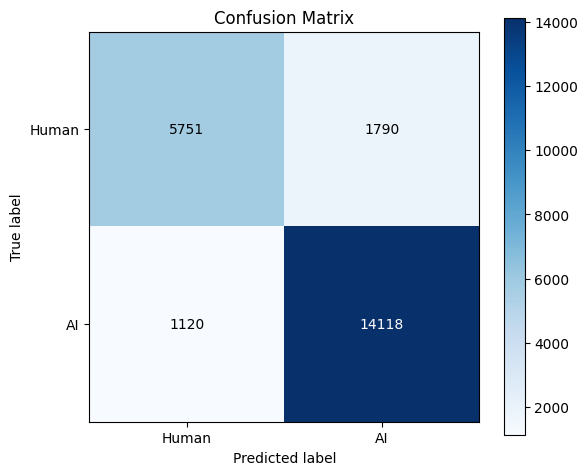


Visualization complete!


In [ ]:
train_single_classifier(classifier_name='svm_linear',cv_folds=10)